In [79]:
import json
import pandas as pd
import os.path as osp
import numpy as np
import spacy
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, plot_confusion_matrix
from sklearn.model_selection import train_test_split

## Preprocessing
### Pipeline

For pre-processing we use SpaCy library and search for matches according to the following rules: 
- is stop word
- is punctuation
- is like number
- is like email
- is like url
- is time in format hh:mm

If token matches to any of these rules, it's removed. Also, we take the lemma of the token instead of the presented form.

In [80]:
data_path = osp.join(osp.dirname(osp.abspath("")), "Lab1_News_Parser", "data")


with open(osp.join(data_path, "corpus.json")) as fp:
    corpus = json.load(fp)
    
preprocessing_patterns = [
    {"string_id": "stop_word", "pattern": [{"IS_STOP": True}]},
    {"string_id": "punctuation", "pattern": [{"IS_PUNCT": True}]},
    {"string_id": "numerical", "pattern": [{"LIKE_NUM": True}]},
    {"string_id": "email", "pattern": [{"LIKE_EMAIL": True}]},
    {"string_id": "url", "pattern": [{"LIKE_URL": True}]},
    {"string_id": "time", "pattern": [{"TEXT": {"REGEX": "\d{2}\:\d{2}"}}]},
]

In [81]:
from typing import List, Dict, Union
from spacy.tokens import Doc, Token
from spacy.matcher import Matcher
from srsly import read_json


class FilterTextPreprocessing:
    def __init__(self, nlp, 
        patterns: List[Dict[str, Union[str, List[Dict]]]]) :
        
        Doc.set_extension('bow', default=[], force=True)
        Token.set_extension('keep', default=True, force=True)
        self.matcher = Matcher(nlp.vocab)
        
        for patt_obj in patterns:
            string_id = patt_obj.get('string_id')
            pattern = patt_obj.get('pattern')
            self.matcher.add(string_id, self.on_match, pattern)
   
    def on_match(self, matcher, doc, i, matches):
        _, start, end = matches[i]
        for tkn in doc[start:end]:
            tkn._.keep = False
              
    def __call__(self, doc) :
        self.matcher(doc)
        doc._.bow = [tkn.lemma_.lower() for tkn in doc if tkn._.keep]
        return doc
    
def train_and_prepare_report(pipeline, X_train, y_train, X_test, y_test):
    trained_pipeline = pipeline.fit(X_train, y_train)
    print(classification_report(y_test, trained_pipeline.predict(X_test)))
    plot_confusion_matrix(trained_pipeline, X_test, y_test,
                             display_labels=np.unique(y_test),
                             cmap=plt.cm.Blues,
                             xticks_rotation='vertical')
    return pipeline['clf']

In [82]:
df_corpus = pd.DataFrame(corpus["catalog"])
nlp = spacy.load("en_core_web_sm")
preprocessor = FilterTextPreprocessing(nlp, preprocessing_patterns)
nlp.add_pipe(preprocessor, last=True)
len(df_corpus)

4895

In [83]:
df_corpus.head()

,article_id,category,tags,text,title
0,https://www.bbc.com/news/world-asia-55689843,world,"Volcanoes,Indonesia","Indonesia's Mount Semeru has erupted, pouring ...",Mount Semeru: Erupting volcano spews ash above...
1,https://www.bbc.com/news/uk-england-55690983,world,"Europe migrant crisis,Dover,France,Immigration...",Two small boats with a total of 36 migrants on...,Two migrant boats intercepted in English Channel
2,https://www.bbc.com/news/world-asia-55684149,world,"Nepal,China,Pakistan,Mountaineering",A team of 10 Nepali climbers has set a new wor...,Nepali climbers make history with winter summi...
3,https://www.bbc.com/news/world-australia-55683035,world,"Coronavirus pandemic,Australia,Victoria",The sight of some of the world's biggest tenni...,Tennis stars' arrival angers stranded Australians
4,https://www.bbc.com/news/world-us-canada-55586677,world,"Nancy Pelosi,Donald Trump,US Capitol riots,Uni...",Donald Trump has been impeached - again. So wh...,Trump impeachment: When will he go on trial in...


In [84]:
df_corpus.text[42]

'With the US due to complete the withdrawal of another 2,000 troops from Afghanistan, the Afghan vice-president tells the BBC the US made a mistake in conceding too much to the Taliban. Amrullah Saleh says the American mission, which began 20 years ago, is not yet accomplished. Last year President Donald Trump made a peace deal with the Taliban and agreed to drastically reduce US troops. Mr Saleh says the pull-out risks more violence in the unstable country. The Afghan government has been battling the Taliban, a hard-line Islamic movement, as the group tries to tighten its grip on parts of the country. The current US presence in Afghanistan dates to 2001 when soldiers invaded to remove the Taliban from power, following the 9/11 terrorist attacks. But the movement regrouped and by 2018 was active in more than two-thirds of Afghanistan, threatening the elected government. Thousands have been killed, including 2,400 US soldiers. Mr Trump has been clear that he is determined to withdraw al

In [85]:
doc = nlp(df_corpus.text[42])

In [86]:
print(*doc._.bow, sep=' ')


complete withdrawal troop afghanistan afghan vice president tell bbc mistake concede taliban amrullah saleh say american mission begin year ago accomplish year president donald trump peace deal taliban agree drastically reduce troop mr saleh say pull risk violence unstable country afghan government battle taliban hard line islamic movement group try tighten grip part country current presence afghanistan date soldier invade remove taliban power follow terrorist attack movement regroup active third afghanistan threaten elect government thousand kill include soldier mr trump clear determined withdraw troop country vice president saleh tell bbc talk taliban mistake mr trump administration error give group massive concession deal sign february say nato ally withdraw troop month taliban uphold promise stop attack taliban promise allow al qaeda militant operate area control condition start negotiation afghan government taliban demand man release afghan prison final prisoner set free august ye

As pre-processing takes a while, we provide the saved results and load them if file exists. To launch the pipeline by yourself, delete the `corpus_prepared.json` file from `root/Lab1_News_Parser/data`

In [87]:
if not osp.exists(osp.join(data_path, "corpus_prepared.json")):
    df_corpus_lemmatized = df_corpus.copy()
    df_corpus_lemmatized['text'] = df_corpus['text'].apply(lambda x: " ".join(nlp(x)._.bow))
    with open(osp.join(data_path, "corpus_prepared.json"), "w") as fp:
        corpus = json.dump({"catalog": df_corpus_lemmatized.to_dict("records")}, fp, indent=4, ensure_ascii=False)
else:
    with open(osp.join(data_path, "corpus_prepared.json")) as fp:
        df_corpus_lemmatized = pd.DataFrame(json.load(fp)["catalog"])

In [88]:
display(len(df_corpus_lemmatized))
df_corpus_lemmatized.head()

4895

,article_id,category,tags,text,title
0,https://www.bbc.com/news/world-asia-55689843,world,"Volcanoes,Indonesia",indonesia mount semeru erupt pour ash smoke es...,Mount Semeru: Erupting volcano spews ash above...
1,https://www.bbc.com/news/uk-england-55690983,world,"Europe migrant crisis,Dover,France,Immigration...",small boat total migrant board intercept cross...,Two migrant boats intercepted in English Channel
2,https://www.bbc.com/news/world-asia-55684149,world,"Nepal,China,Pakistan,Mountaineering",team nepali climber set new world record reach...,Nepali climbers make history with winter summi...
3,https://www.bbc.com/news/world-australia-55683035,world,"Coronavirus pandemic,Australia,Victoria",sight world big tennis star touch forthcoming ...,Tennis stars' arrival angers stranded Australians
4,https://www.bbc.com/news/world-us-canada-55586677,world,"Nancy Pelosi,Donald Trump,US Capitol riots,Uni...",donald trump impeach president history twice s...,Trump impeachment: When will he go on trial in...


In [89]:
df_corpus_lemmatized.drop(columns=["article_id", "tags"], inplace=True)

<AxesSubplot:xlabel='category'>

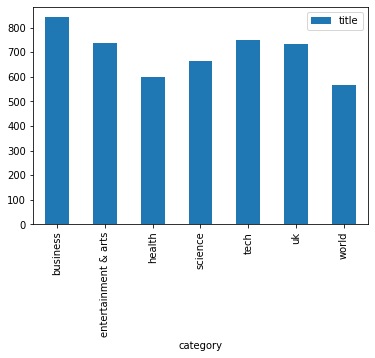

In [90]:
df_corpus_lemmatized.groupby('category').count().plot.bar(y='title')

As you can see, the dataset is pretty balanced.

In [91]:
X = df_corpus_lemmatized['text']
Y = df_corpus_lemmatized['category']

In [92]:
X_train, X_test, y_train, y_test = map(np.array, train_test_split(X, Y, test_size=0.2))

In [93]:
X_train.shape, X_test.shape

((3916,), (979,))

## Classification
### LogisticRegression

In all experiments we use `TfifdVectorizer` which ignores words that appear in less than 3 documents, applies sublinear tf scaling and builds unigrams, bigrams, trigrams.

In [94]:
from sklearn.linear_model import LogisticRegression
logistic_pipeline = Pipeline([('vect', TfidfVectorizer(min_df=3, sublinear_tf=True, ngram_range=(1, 3))),
                     ('clf', LogisticRegression())])

                      precision    recall  f1-score   support

            business       0.62      0.68      0.65       168
entertainment & arts       0.72      0.83      0.77       133
              health       0.81      0.71      0.76       144
             science       0.79      0.79      0.79       132
                tech       0.58      0.58      0.58       153
                  uk       0.55      0.61      0.58       126
               world       0.79      0.59      0.68       123

            accuracy                           0.68       979
           macro avg       0.70      0.68      0.69       979
        weighted avg       0.69      0.68      0.68       979



LogisticRegression()

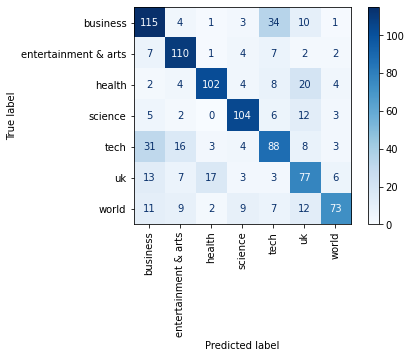

In [95]:
train_and_prepare_report(logistic_pipeline, X_train, y_train, X_test, y_test)

As shows the performance result, we achieve insignificant quality. In the confusion matrix you can find the reason: our model tends to mess up with some categories: 
- business with uk, tech, world; 
- e & a with tech; 
- health with uk;
- science with uk, world. 

It's quite obvious as usually our news belong to several categories at the same time and it's difficult to separate them with straight-forward single-label classification approach. Also, after manual checking of the dataset, we found out that we have some dublicates in different categories. In order to improve our results, we removed categories that lead to mess and used only 4: business, e&a, health, science. And we also removed the dublicates within these classes.

In [96]:
df_corpus_lemmatized_cleaned=df_corpus_lemmatized[df_corpus_lemmatized.category.isin(['business', 'entertainment & arts', 'health', 'science'])].drop_duplicates(subset=['title']).reset_index(drop=True)
display(len(df_corpus_lemmatized_cleaned))
df_corpus_lemmatized_cleaned.head()

2768

,category,text,title
0,business,ten thousand small business receive insurance ...,Insurers must pay many small firms for Covid l...
1,business,week end brexit transition period haulier face...,Brexit: 'Most difficult week I've had in this ...
2,business,donald trump take final swipe china big compan...,Trump takes final swipes at China's big companies
3,business,samsung new flagship galaxy s smartphone work ...,Samsung Galaxy S21 Ultra: Does stylus spell en...
4,business,tesla ask recall model s model x vehicle issue...,"Tesla asked to recall 158,000 cars over safety..."


<AxesSubplot:xlabel='category'>

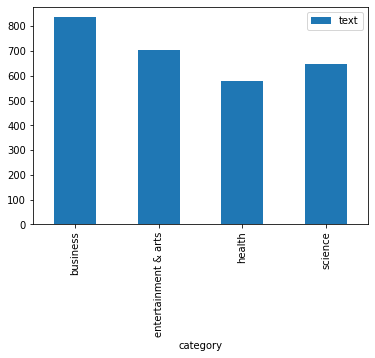

In [97]:
df_corpus_lemmatized_cleaned.drop(columns=["title"], inplace=True)
df_corpus_lemmatized_cleaned.groupby('category').count().plot.bar()

We still have the balanced dataset, but with the fewer classes.

In [98]:
X = df_corpus_lemmatized_cleaned['text']
Y = df_corpus_lemmatized_cleaned['category']
X_train, X_test, y_train, y_test = map(np.array, train_test_split(X, Y, test_size=0.2))
X_train.shape, X_test.shape

((2214,), (554,))

                      precision    recall  f1-score   support

            business       0.90      0.90      0.90       160
entertainment & arts       0.93      0.94      0.94       167
              health       0.94      0.93      0.93        99
             science       0.90      0.90      0.90       128

            accuracy                           0.92       554
           macro avg       0.92      0.92      0.92       554
        weighted avg       0.92      0.92      0.92       554



LogisticRegression()

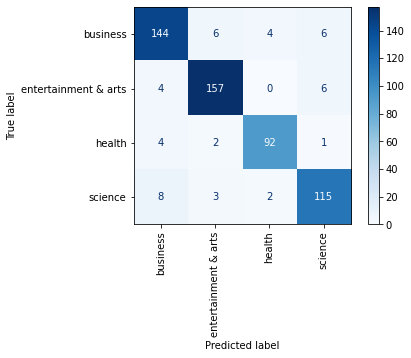

In [99]:
from sklearn.linear_model import LogisticRegression
logistic_pipeline = Pipeline([('vect', TfidfVectorizer(min_df=3, sublinear_tf=True, ngram_range=(1, 3))),
                     ('clf', LogisticRegression())])
train_and_prepare_report(logistic_pipeline, X_train, y_train, X_test, y_test)

This result is much better, we have a slight fall in precision and recall for business and science. Of course, our categories are quite connected with each-other, so this misunderstanding isn't a surprise.

In the following experiments we will use the cropped dataset.

### KNN Classifier

In [100]:
from sklearn.neighbors import KNeighborsClassifier
knn_pipeline = Pipeline([('vect', TfidfVectorizer(min_df=3, sublinear_tf=True, ngram_range=(1, 3))),
                     ('clf', KNeighborsClassifier(n_neighbors=7))])

                      precision    recall  f1-score   support

            business       0.87      0.89      0.88       160
entertainment & arts       0.94      0.88      0.91       167
              health       0.87      0.90      0.89        99
             science       0.85      0.88      0.86       128

            accuracy                           0.89       554
           macro avg       0.88      0.89      0.89       554
        weighted avg       0.89      0.89      0.89       554



KNeighborsClassifier(n_neighbors=7)

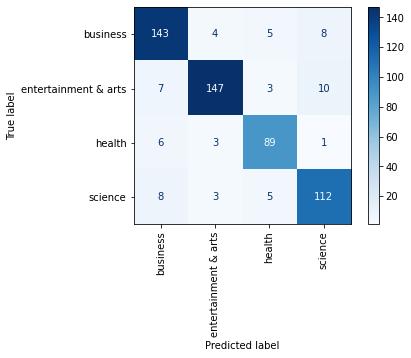

In [101]:
train_and_prepare_report(knn_pipeline, X_train, y_train, X_test, y_test)

As was mentioned, due to the strong connection between some categories, our KNN model tend to mispredict boundary news, so we have fewer accuracy and f1-score compared to logistic regression.
We experimented with number of neighbors and our emperical results show that optimum is 7. With `n_neighbors != 7` the algorithm's quality decreases.

### Decision Tree Classifier

In [102]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
tree_pipeline = Pipeline([('vect', TfidfVectorizer(min_df=3, sublinear_tf=True, ngram_range=(1, 3))),
                     ('clf', DecisionTreeClassifier(random_state=42))])

                      precision    recall  f1-score   support

            business       0.73      0.71      0.72       160
entertainment & arts       0.79      0.73      0.76       167
              health       0.67      0.80      0.73        99
             science       0.70      0.68      0.69       128

            accuracy                           0.73       554
           macro avg       0.72      0.73      0.72       554
        weighted avg       0.73      0.73      0.73       554



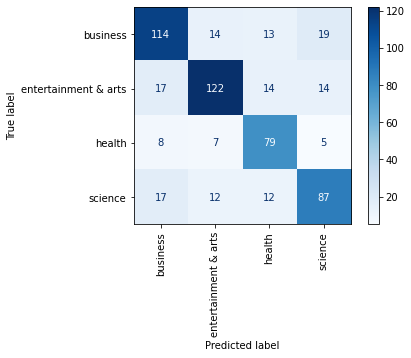

In [103]:
tree = train_and_prepare_report(tree_pipeline, X_train, y_train, X_test, y_test)

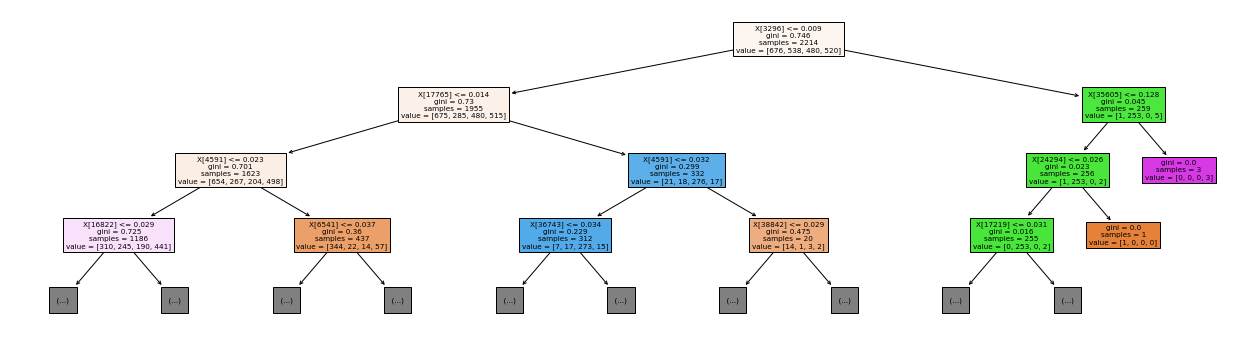

In [104]:
plt.figure(figsize=(22, 6))
plot_tree(tree, max_depth=3, filled=True)
plt.show()

The greatest advantage of the decision tree classifier is the interpretability of the results. However, as we have very highly dimensional feature space, in our case we can interpret the desicion of the algorithm but it's still quite complicated. Overall, this algorithm shows the lowest score as one particular feature may not represent the key information for the classification and it's not the best approach to remove the feature at each step.

From the tree graph we see that already at the third step some final decisions are made.

### Random Forest Classifier

In [105]:
from sklearn.ensemble import RandomForestClassifier
random_forest_pipeline = Pipeline([('vect', TfidfVectorizer(min_df=3, sublinear_tf=True, ngram_range=(1, 3))),
                     ('clf', RandomForestClassifier(n_estimators=200, random_state=42))])

                      precision    recall  f1-score   support

            business       0.85      0.93      0.89       160
entertainment & arts       0.95      0.85      0.90       167
              health       0.92      0.91      0.91        99
             science       0.86      0.88      0.87       128

            accuracy                           0.89       554
           macro avg       0.89      0.89      0.89       554
        weighted avg       0.89      0.89      0.89       554



RandomForestClassifier(n_estimators=200, random_state=42)

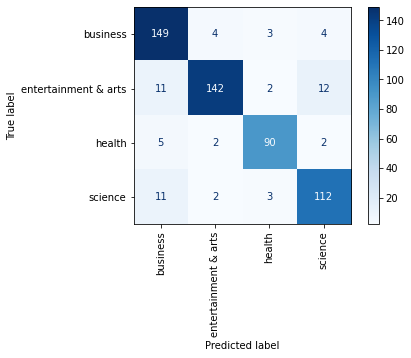

In [106]:
train_and_prepare_report(random_forest_pipeline, X_train, y_train, X_test, y_test)

We can enhance the situation with 200 decision trees instead of single one. We still achieve lower metrics compared to logistic regression, it's almost like `KNN` metrics

### Extra Trees Classifier

In [107]:
from sklearn.ensemble import ExtraTreesClassifier
extra_trees_pipeline = Pipeline([('vect', TfidfVectorizer(min_df=3, sublinear_tf=True, ngram_range=(1, 3))),
                     ('clf', ExtraTreesClassifier(n_estimators=200, random_state=42))])

                      precision    recall  f1-score   support

            business       0.87      0.93      0.90       160
entertainment & arts       0.93      0.90      0.91       167
              health       0.94      0.92      0.93        99
             science       0.91      0.88      0.90       128

            accuracy                           0.91       554
           macro avg       0.91      0.91      0.91       554
        weighted avg       0.91      0.91      0.91       554



ExtraTreesClassifier(n_estimators=200, random_state=42)

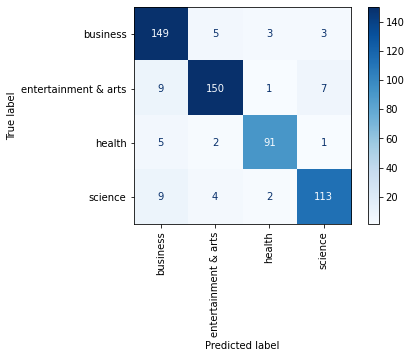

In [108]:
train_and_prepare_report(extra_trees_pipeline, X_train, y_train, X_test, y_test)

A random selection of split points and building the trees on the whole dataset allows the ExtraTree ensemble to achieve higher F1 score for all categories compared to Random Forest.  

### Naive Bayes

In [109]:
from sklearn.naive_bayes import MultinomialNB
nb_pipeline = Pipeline([('vect', TfidfVectorizer(min_df=3, sublinear_tf=True, ngram_range=(1, 3))),
                     ('clf', MultinomialNB(alpha=0.01))])

                      precision    recall  f1-score   support

            business       0.92      0.89      0.90       160
entertainment & arts       0.91      0.93      0.92       167
              health       0.96      0.93      0.94        99
             science       0.90      0.94      0.92       128

            accuracy                           0.92       554
           macro avg       0.92      0.92      0.92       554
        weighted avg       0.92      0.92      0.92       554



MultinomialNB(alpha=0.01)

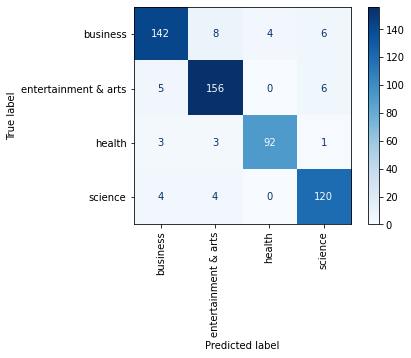

In [110]:
train_and_prepare_report(nb_pipeline, X_train, y_train, X_test, y_test)

As naive bayes gives frequency-based probability estimate equal to zero if a given class and feature value never occur together in the training data, we use alpha smoothing parameter. As we use smoothed tf-idf approach (usually, bayes prefers word-counts approach), our alpha value is set as `0.01` which was found emperically. Overall, the achieved results are very close to `Logistic Regression`.

### SVM

In [118]:
from sklearn.svm import SVC
svc_pipeline = Pipeline([('vect', TfidfVectorizer(min_df=3, sublinear_tf=True, ngram_range=(1, 3))),
                     ('clf', SVC(C=2))])

                      precision    recall  f1-score   support

            business       0.92      0.91      0.92       160
entertainment & arts       0.94      0.95      0.95       167
              health       0.94      0.92      0.93        99
             science       0.91      0.92      0.91       128

            accuracy                           0.93       554
           macro avg       0.93      0.93      0.93       554
        weighted avg       0.93      0.93      0.93       554



SVC(C=2)

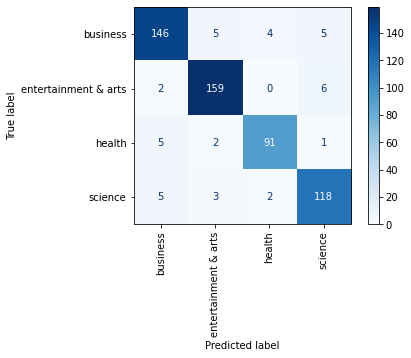

In [119]:
train_and_prepare_report(svc_pipeline, X_train, y_train, X_test, y_test)

SVM in cases when number of samples is much lower than number of features tends to over-fit (our case). Choosing the regularization strength and kernel function properly can help to avoid it. In our case we found that the best result is achieved with `C=2`. And the result of the algorithm is the highest, some hard cases are classified more accurate compared to the all previous algorithms.

### Conclusion

As can be noticed, almost all of the applied algorithms shows quite similar results. We have high accuracy and f1-score, so probably for further improvements may require:
- Appliance of more complicated algorithms;
- Extending the number of samples for each class;
- Thorough data cleaning, removing boundary news;
- Using another feature extraction technique (e.g Word2Vec)

*Note:* We don't fix seeds for the random split generator, so from launch-to-launch the results may differ, but insignificantly.

### Grid Search

Below we provide an example of tuning parameters for some of our algorithms). It's quite time-consuming, so we include only one example.

In [113]:
from sklearn.model_selection import GridSearchCV
parameters = {
    'vect__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'vect__use_idf': (True, False),
    'clf__C': (0.5, 1, 2, 4),
}

In [114]:
gs_clf = GridSearchCV(svc_pipeline, parameters, cv=5, n_jobs=-1)

In [115]:
gs_clf.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('vect',
                                        TfidfVectorizer(min_df=3,
                                                        ngram_range=(1, 3),
                                                        sublinear_tf=True)),
                                       ('clf', SVC(C=4))]),
             n_jobs=-1,
             param_grid={'clf__C': (0.5, 1, 2, 4),
                         'vect__ngram_range': [(1, 1), (1, 2), (1, 3)],
                         'vect__use_idf': (True, False)})

In [116]:
gs_clf.best_params_

{'clf__C': 2, 'vect__ngram_range': (1, 3), 'vect__use_idf': True}

In [117]:
gs_clf.best_score_

0.9191505878267264

### Conclusion